# Advanced Modelling

Building on our baseline models, we will build more regorously through cross validation and hyper parameter optimization. In this notebook, we will cross validate on our logistic regression model and random forest model. We will also explore AdaBoost classifier on our dataset

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [8]:
df_final = pd.read_csv("Wii_final.csv")

In [10]:
df_final = df_final.drop('Unnamed: 0', axis=1)

In [11]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 24 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   label                                         200 non-null    int64  
 1   age                                           200 non-null    int64  
 2   sex                                           200 non-null    int64  
 3   grip_r1                                       200 non-null    float64
 4   grip_l1                                       200 non-null    float64
 5   health_rating                                 200 non-null    int64  
 6   crouching_difficulty                          200 non-null    int64  
 7   lifting_difficulty                            200 non-null    int64  
 8   reaching_overhead_difficulty                  200 non-null    int64  
 9   walking_difficulty                            200 non-null    int

In [29]:
# Defining our X and y variables 
X = df_final[["grip_l1", "avg_grip_strength", "grip_difference", \
              "has_near_fallen", "health_rating", "walking_difficulty", "age"
             ]]
y = df_final["has_fallen"]

In [30]:
# Train / test split. 20% test size
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.2,random_state=1)

In [36]:
# Instanitate model. Max iterations at 1000
logreg = LogisticRegression(max_iter=1000, random_state=1)

# Fit model on 5 folds
scores = cross_val_score(logreg, X_train, y_train, cv = 5)
print(scores)

[0.5     0.75    0.625   0.71875 0.625  ]


In [32]:
print(f'Average Score: {np.mean(scores)}')

Average Score: 0.64375


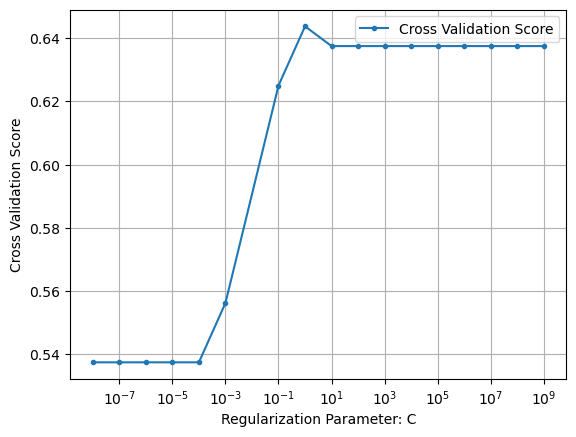

In [35]:
#Store the results
cross_validation_scores = []

C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

#Do some cross validation
for c in C_range:
    LR_model = LogisticRegression(C=c,random_state=1, max_iter=1000)
    
    # the cross validation score (mean of scores from all folds)
    cv_score = np.mean(cross_val_score(LR_model, X_train, y_train, cv = 5))
    
    cross_validation_scores.append(cv_score)

plt.figure()
plt.plot(C_range, cross_validation_scores,label="Cross Validation Score",marker='.')
plt.legend()
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show();

We can observe the highest score occurs at C value of 10^0 (1). We will use this for our logistic regression (even though this is default value)

In [39]:
X = df_final[["grip_l1", "avg_grip_strength", "grip_difference", \
              "has_near_fallen", "health_rating", "walking_difficulty", "age"
             ]]
y = df_final["has_fallen"]

# Train and test split
# Test size = 20% of total data
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 42
)

# scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# logistic regression model
logreg = LogisticRegression(C=1) # instantiate. Inputing C=1 as our optimal regularization paramater 
logreg.fit(X_train, y_train)  # fit
y_predict = logreg.predict(X_test) # test

test_accuracy = accuracy_score(y_test, y_predict)

print(f'Test accuracy: {test_accuracy}')

Test accuracy: 0.775


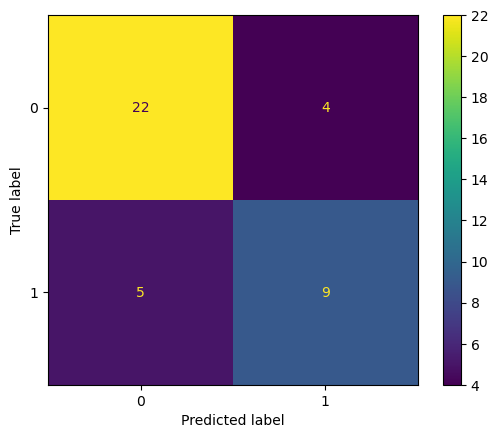

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        26
           1       0.69      0.64      0.67        14

    accuracy                           0.78        40
   macro avg       0.75      0.74      0.75        40
weighted avg       0.77      0.78      0.77        40



<Figure size 640x480 with 0 Axes>

In [65]:
# predicting y based on Logistic regression on X test
y_pred_logreg = logreg.predict(X_test)

# Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_logreg)
ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()
plt.savefig('logreg_model_eval.png')

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_logreg))

Evaluating our logistic regression model, we can see a recall score of 64% and precision of 69%. Considering our use case of classifying whether a senior will fall or not, we will consider the model with the higher recall score since there is little "consequence" of mis-classifying someone as on a path to falling as opposed to the alternate. 

# Random Forest Classifier

In [59]:
rfc = RandomForestClassifier(random_state=42)

# listing out our paramaters we will attempt to optimize
params = {
    'max_depth': [None, 5, 10, 20, 30, 40, 50],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'min_samples_split': [2, 4, 6, 8, 10],
    'n_estimators': [10, 20, 30, 40, 50]
}

# 5 fold grid search cross valildation
grid_search = GridSearchCV(estimator=rfc, param_grid=params, cv=5,
                           scoring='accuracy',
                           n_jobs=-1
)

# Fitting on train data
grid_search.fit(X_train, y_train)

# Storing our best params and best score into variables
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Ideal parameters: {best_params}')
print(f'Best cross-validated score: {best_score}')

Ideal parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 30}
Best cross-validated score: 0.6125


In [63]:
# Using the best params from above. Instantiating random forest model on those paramaters
rfc = RandomForestClassifier(n_estimators = 30, 
                              max_depth = None, 
                              min_samples_leaf = 2,
                              min_samples_split = 10,
                              random_state = 42
                              )

rfc.fit(X_train, y_train) # Fit on train data
y_predict = rfc.predict(X_test) # Predict
accuracy = accuracy_score(y_test, y_predict) 
print(f'Accuracy: {accuracy}')

Accuracy: 0.75


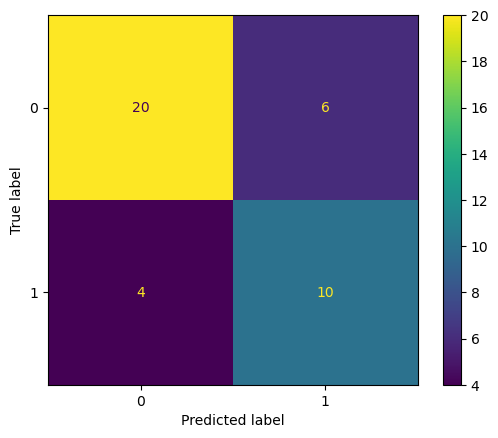

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        26
           1       0.62      0.71      0.67        14

    accuracy                           0.75        40
   macro avg       0.73      0.74      0.73        40
weighted avg       0.76      0.75      0.75        40



<Figure size 640x480 with 0 Axes>

In [66]:
# predicting y based on random forest classifier on X test
y_pred_rfc = rfc.predict(X_test)

# Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_rfc)
ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()
plt.savefig('rfc_model_eval.png')

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_rfc))

Our random forest classifier performed better than our logistic regression model in terms of recall with a score of 71%. In other words, of the 14 cases of "falls" in our test dataset, our model captured 10 cases correctly. We will explore if this can be improved.

# AdaBoost Classifier

In [88]:
# Instantiate Adaboost classifier on 19 estimators
abc = AdaBoostClassifier(n_estimators=19)

# Fitting on train dataset
abc.fit(X_train, y_train)

# Predict on test set
y_pred_abc = abc.predict(X_test)
print(classification_report(y_test, y_pred_abc))

              precision    recall  f1-score   support

           0       0.91      0.81      0.86        26
           1       0.71      0.86      0.77        14

    accuracy                           0.82        40
   macro avg       0.81      0.83      0.82        40
weighted avg       0.84      0.82      0.83        40



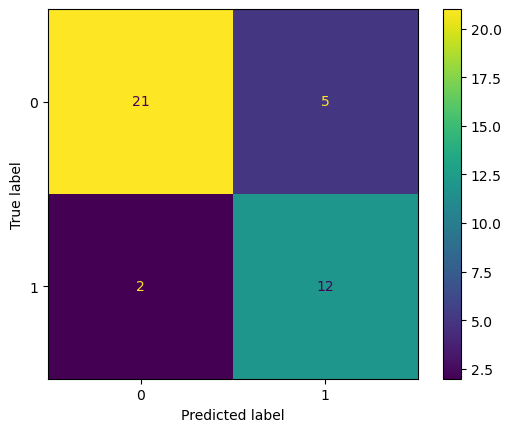

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.81      0.86        26
           1       0.71      0.86      0.77        14

    accuracy                           0.82        40
   macro avg       0.81      0.83      0.82        40
weighted avg       0.84      0.82      0.83        40



In [89]:
# Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_abc)
ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_abc))

Our AdaBoost classifier performed the best in terms of recall score. It yielded a recall score of 86%. In other words, of the 14 cases of falls, our AdaBoost classifier was able to correctly classify 12 of them and only missing 2. 